In [1]:
import sys, os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
import matplotlib.pyplot as plt
%matplotlib inline

Some ligand conformer cannot be properly generated by RDKit. 
The curated_Zinc_analogs_BBBP_update.csv is a updated version of curated_Zinc_analogs_BBBP_select.csv after removing these cases.

In [2]:
df = pd.read_csv('dataset/curated_Zinc20_instock/curated_Zinc_analogs_BBBP_update.csv')
df.head(2)

,zinc_id,new_smile,tanimoto_sim,cluster,BBBP,ligand_id
0,20258057,O=C(c1c[nH]c(=O)[nH]1)N1CCNCC1,0.333,13,Permeable,1
1,42420199,CCOC(=O)C(=O)N1CCNCC1,0.337,13,Permeable,2


Add HeavyAtomCount column

In [3]:
LigandDescriptor = ['HeavyAtomCount']
DescCalc = MolecularDescriptorCalculator(LigandDescriptor)

def GetRDKitDescriptors(smile):
    # Function for the calculation of ligand descriptors
    mol = Chem.MolFromSmiles(smile)
    mol.UpdatePropertyCache(strict=False)
    Chem.GetSymmSSSR(mol)
    return DescCalc.CalcDescriptors(mol)

In [4]:
Features = []

for i in df.new_smile.tolist():
    Features.append(GetRDKitDescriptors(i))
    
ss = pd.DataFrame(Features, columns=LigandDescriptor)
df = pd.concat([df,ss], axis=1, ignore_index=False)

In [5]:
df.head(2)

,zinc_id,new_smile,tanimoto_sim,cluster,BBBP,ligand_id,HeavyAtomCount
0,20258057,O=C(c1c[nH]c(=O)[nH]1)N1CCNCC1,0.333,13,Permeable,1,14
1,42420199,CCOC(=O)C(=O)N1CCNCC1,0.337,13,Permeable,2,13


Add Lin_F9 score (docked score of best-scored pose for each ligand)

In [6]:
f1 = open('screen/LinF9_score/LinF9_inactive_Hel.txt','r')
LinF9_score = [round(float(x.strip('\n')),3) for x in f1.readlines()]
f1.close()

In [7]:
df['LinF9_score'] = pd.Series(LinF9_score, index=df.index)
df['LinF9_LE'] = df['LinF9_score']/df['HeavyAtomCount']
df['LinF9'] = df['LinF9_score'].map(lambda x: round(x*(-0.73349),3))
df.head(3)

,zinc_id,new_smile,tanimoto_sim,cluster,BBBP,ligand_id,HeavyAtomCount,LinF9_score,LinF9_LE,LinF9
0,20258057,O=C(c1c[nH]c(=O)[nH]1)N1CCNCC1,0.333,13,Permeable,1,14,-5.353,-0.382357,3.926
1,42420199,CCOC(=O)C(=O)N1CCNCC1,0.337,13,Permeable,2,13,-4.712,-0.362462,3.456
2,2456218,O=C(O)C(=O)N1CCNCC1,0.338,13,Permeable,3,11,-4.271,-0.388273,3.133


### Screen by LinF9 score

In [8]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 17,
        }
font1 = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 16,
        }

Text(0.5, 1.0, 'Docking results of 13267 compounds')

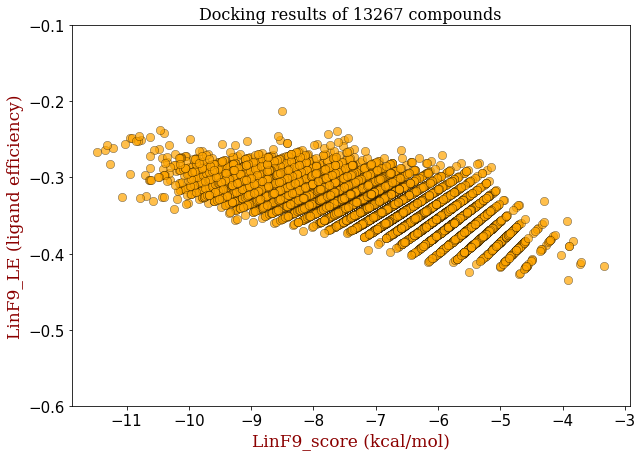

In [9]:
plt.figure(figsize=[10,7])
plt.scatter(df['LinF9_score'],df['LinF9_LE'],edgecolor='k',color='orange', s=70, alpha=0.7,linewidths=0.4)
plt.ylim(-0.6,-0.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('LinF9_score (kcal/mol)', fontdict=font)
plt.ylabel('LinF9_LE (ligand efficiency)', fontdict=font)
plt.title('Docking results of 13267 compounds',fontdict=font1)

Screen out 50%

In [10]:
df = df.sort_values(by='LinF9_score', ascending=True)
Num_half = len(df)//2
df1 = df.iloc[:Num_half]

Text(0.5, 1.0, 'Screening results (remaining 6633 compounds)')

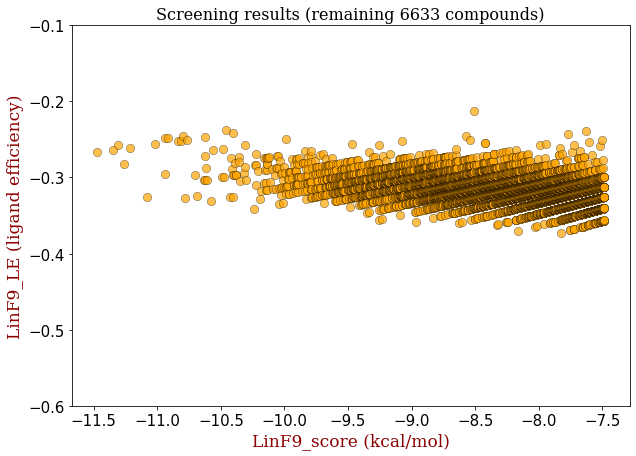

In [11]:
plt.figure(figsize=[10,7])
plt.scatter(df1['LinF9_score'],df1['LinF9_LE'],edgecolor='k',color='orange', s=70, alpha=0.7,linewidths=0.4)
plt.ylim(-0.6,-0.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('LinF9_score (kcal/mol)', fontdict=font)
plt.ylabel('LinF9_LE (ligand efficiency)', fontdict=font)
plt.title('Screening results (remaining %d compounds)'%len(df1),fontdict=font1)

In [12]:
df1 = df1.sort_values(by='ligand_id')
df1.to_csv('screen/screen_LinF9/round1_inactive_Hel.csv', index=False)

After round1_screening, it remains 6633 compounds.